Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json

import torchvision
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import ResNet50_Weights

from torch.utils.tensorboard import SummaryWriter


In [2]:
# label definitions
ALLERGENS = [
    "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
    "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
    "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
]

Store Dataset Paths

In [3]:
dataset_directory = "../Dataset Generation/dataset"

# Image and label directory arrays
images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)

x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

Dataset Class

In [4]:
# Dataset class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

EarlyStopping

In [5]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

Model Saving

In [6]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model(epoch, model, optimizer, training_losses, validation_losses, filename):
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
        "validation_losses": validation_losses
    }, filename)

Training Function

In [7]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_one_epoch(dataloader, model, loss_fn, optimizer, device, writer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        # image grid for tensorboard - makes file size too big for github
        # img_grid = torchvision.utils.make_grid(images)
        # writer.add_image('Training_Images', img_grid, global_step=batch)

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"Loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    avg_train_loss = total_loss / len(dataloader)
    print(f"Train loss for this epoch: {avg_train_loss:.7f}")

    # Return average training loss for this epoch
    return avg_train_loss

Validation Function

In [8]:
def validate_one_epoch(dataloader, model, loss_fn, device):
    model.eval()
    running_val_loss = 0.0
    running_correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > hyperparameters['prediction_threshold'])
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()
            running_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(dataloader)
    val_accuracy = 100 * running_correct / len(dataloader.dataset)
    print(f"Validation loss for this epoch: {val_loss:.7f}")

    # Return average validation loss for this epoch
    return val_loss, val_accuracy

Testing Function

In [9]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def test_loop(dataloader, model, hyperparameters, device, label, writer):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []
    all_probabilities = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # Apply sigmoid to convert logits to get probabilities 0-1
            preds = (probs > hyperparameters['prediction_threshold']) # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_probabilities.append(probs.cpu().numpy())
            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    all_probabilities = np.concatenate(all_probabilities, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    accuracy = 100 * correct / total
    #print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    writer.add_scalar('Test_Accuracy For Best Model State (lowest val loss)', accuracy)
    writer.add_pr_curve('Test_Precision_Recall_Curve For Best Model State (lowest val loss)', all_actual, all_probabilities, global_step=0)

    matrix = confusion_matrix(all_actual, all_predictions)
    matrix_figure = plt.figure(figsize=(4, 3))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar=False,
        xticklabels=["Pred Negative", "Pred Positive"],
        yticklabels=["True Negative", "True Positive"]
    )
    plt.title(f"Confusion Matrix: {ALLERGENS[label]}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    # plt.show()
    writer.add_figure('Confusion_Matrix on Test Set For Best Model State (lowest val loss)', matrix_figure)

    # print("\n\nClassification Report:")
    # # Sklearn classification report
    # report = classification_report(all_actual, all_predictions)
    # print(report)

Training Function for Single Allergen Label

In [15]:
def train_for_allergen_label(label, x, y, hyperparameters):
    y = y[:, label] # get label values for specific allergen label

    # positives = np.sum(y==1)
    # negatives = np.sum(y==0)
    # print(f"Before resampling: {positives} positives, {negatives} negatives")

    resampler = RandomUnderSampler() # create random under sampler from unbalanced-learn library
    x_balanced, y_balanced = resampler.fit_resample(x, y) # balance x and y
    y_balanced = y_balanced.reshape(-1,1) # iterative_train_test_split expects 2d array

    # positives = np.sum(y_balanced==1)
    # negatives = np.sum(y_balanced==0)
    # print(f"After resampling: {positives} positives, {negatives} negatives\n")

    x_train, y_train, x_test, y_test = iterative_train_test_split(x_balanced, y_balanced, 0.3) # train test split

    # Transform images to tensors and resize
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

    train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
    val_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)
    test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

    # Create Train Test Val DataLoaders. Pin memory enabled for faster transfer to the GPU
    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False, pin_memory=True)

    # set accelerator device cpu/gpu
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
    print(f"Using {device} device")

    # Define model - ResNet50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = nn.Linear(model.fc.in_features, 1) # altered final layer for single output binary classification
    model = model.to(device)

    # Tensorboard writer
    writer = SummaryWriter(f'runs/{ALLERGENS[label]}/{model._get_name()}/BatchSize {batch_size} LR {learning_rate}') # change run name for every run
    # track hyperparameters on tensorboard
    writer.add_hparams(hyperparameters,{})

    example_input = torch.rand(1, 3, 224, 224).to(device) # add_graph requires sample data for the model
    writer.add_graph(model, example_input) # add model architecture to tensorboard

    for n, transform in enumerate(transform.transforms):
        writer.add_text(f'Transforms/Transform_{n}', str(transform))

    # Loss function and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

    epochs = hyperparameters['epochs']
    best_val_loss = 1_000_000.
    best_epoch = 0
    training_losses = []
    validation_losses = []
    early_stopping = EarlyStopping(hyperparameters['patience'], hyperparameters['delta'])

    # filename for saving the model
    filename = f"saved_models/{ALLERGENS[label]}/{model._get_name()}/BatchSize {batch_size}/LR {learning_rate}/{ALLERGENS[label]}.pt"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train and validate this epoch
        train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device, writer)
        val_loss, val_accuracy = validate_one_epoch(val_dataloader, model, loss_fn, device)

        # add loss scalars for tensorboard
        writer.add_scalar('Training_Loss', train_loss, epoch)
        writer.add_scalar('Validation_Loss', val_loss, epoch)
        writer.add_scalar('Validation_Accuracy', val_accuracy, epoch)

        # Append losses for this epoch
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # save_model(epoch, model, optimizer, training_losses, validation_losses, filename) # Save best model as checkpoint (larger file), so that training can be resumed
            torch.save(model, filename) # Save best model
            best_epoch = epoch + 1
            print(f"Saved new best model: {filename}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping\n")
            break
    print(f"Training Complete\n")

    # load the best model before running test loop
    model = torch.load(filename, map_location=device, weights_only=False)

    # Plot train and val losses
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
    # plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss for Allergen Label: ' + ALLERGENS[label])
    # plt.axvline(x=best_epoch, linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    #
    # print("TEST RESULTS FOR BEST MODEL (lowest val loss):\n\n")
    # Run test loop. Produces Confusion matrix + classification report. pass in writer for tensorboard
    test_loop(test_dataloader, model, hyperparameters, device, label, writer)

    # close tensorboard writer
    writer.close()

In [12]:
# tune with different hyperparameter combinations
allergen = 0 # gluten
batch_sizes = [64, 128, 256]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6995301 [    0/34279]
Loss: 0.6833364 [ 6400/34279]
Loss: 0.6859402 [12800/34279]
Loss: 0.6879784 [19200/34279]
Loss: 0.6980870 [25600/34279]
Loss: 0.6939105 [32000/34279]
Train loss for this epoch: 0.7036379
Validation loss for this epoch: 6.6110666
Saved new best model: saved_models/Cereals containing gluten/ResNet/BatchSize 64/LR 0.01/Cereals containing gluten.pt

Epoch 2/100
Loss: 0.7001272 [    0/34279]
Loss: 0.6974890 [ 6400/34279]
Loss: 0.7259363 [12800/34279]
Loss: 0.7255835 [19200/34279]
Loss: 0.7197348 [25600/34279]
Loss: 0.6958414 [32000/34279]
Train loss for this epoch: 0.6971826
Validation loss for this epoch: 0.6988566
Saved new best model: saved_models/Cereals containing gluten/ResNet/BatchSize 64/LR 0.01/Cereals containing gluten.pt

Epoch 3/100
Loss: 0.7085572 [    0/34279]
Loss: 0.6888430 [ 6400/34279]
Loss: 0.6648155 [12800/34279]
Loss: 0.7268530 [19200/34279]
Loss: 0.6635013 [25600/34279]
Loss: 0.6851518 [32000/34279]
Train los

KeyboardInterrupt: 

In [14]:
# tune with different hyperparameter combinations
allergen = 1 # Crustaceans
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7071730 [    0/ 3379]
Loss: 0.7219758 [ 1600/ 3379]
Loss: 0.7048784 [ 3200/ 3379]
Train loss for this epoch: 0.7329833
Validation loss for this epoch: 4.8648152
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 16/LR 0.01/Crustaceans.pt

Epoch 2/100
Loss: 0.6670949 [    0/ 3379]
Loss: 0.6972075 [ 1600/ 3379]
Loss: 0.6699734 [ 3200/ 3379]
Train loss for this epoch: 0.7087905
Validation loss for this epoch: 3.0587919
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 16/LR 0.01/Crustaceans.pt

Epoch 3/100
Loss: 0.8229190 [    0/ 3379]
Loss: 0.6907752 [ 1600/ 3379]
Loss: 0.6801802 [ 3200/ 3379]
Train loss for this epoch: 0.7016803
Validation loss for this epoch: 4.5694754

Epoch 4/100
Loss: 0.7816452 [    0/ 3379]
Loss: 0.6652732 [ 1600/ 3379]
Loss: 0.7281430 [ 3200/ 3379]
Train loss for this epoch: 0.6985591
Validation loss for this epoch: 0.6805424
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 16/LR 0.01

KeyboardInterrupt: 

In [13]:
# tune with different hyperparameter combinations
allergen = 2 # eggs
batch_sizes = [64, 128, 256]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7009673 [    0/25533]
Loss: 0.6065810 [ 6400/25533]
Loss: 0.6978641 [12800/25533]
Loss: 0.6587608 [19200/25533]
Train loss for this epoch: 0.6533324


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss for this epoch: 0.7081161
Saved new best model: saved_models/Eggs/ResNet/BatchSize 64/LR 0.001/Eggs.pt

Epoch 2/100
Loss: 0.6981992 [    0/25533]
Loss: 0.6515403 [ 6400/25533]
Loss: 0.6237907 [12800/25533]
Loss: 0.6344959 [19200/25533]
Train loss for this epoch: 0.6299861
Validation loss for this epoch: 0.6811469
Saved new best model: saved_models/Eggs/ResNet/BatchSize 64/LR 0.001/Eggs.pt

Epoch 3/100
Loss: 0.6346070 [    0/25533]
Loss: 0.5911460 [ 6400/25533]
Loss: 0.6815290 [12800/25533]
Loss: 0.6446455 [19200/25533]
Train loss for this epoch: 0.6197867
Validation loss for this epoch: 0.7028241

Epoch 4/100
Loss: 0.5850579 [    0/25533]
Loss: 0.5689270 [ 6400/25533]
Loss: 0.5590522 [12800/25533]
Loss: 0.6014213 [19200/25533]
Train loss for this epoch: 0.6120825
Validation loss for this epoch: 0.6729960
Saved new best model: saved_models/Eggs/ResNet/BatchSize 64/LR 0.001/Eggs.pt

Epoch 5/100
Loss: 0.6729214 [    0/25533]
Loss: 0.5625225 [ 6400/25533]
Loss: 0.5294040 [1

In [14]:
# tune with different hyperparameter combinations
allergen = 3 # fish
batch_sizes = [32, 64, 128]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7086651 [    0/11991]
Loss: 0.6848783 [ 6400/11991]
Train loss for this epoch: 0.6559124
Validation loss for this epoch: 0.6561025
Saved new best model: saved_models/Fish/ResNet/BatchSize 64/LR 0.001/Fish.pt

Epoch 2/100
Loss: 0.6901214 [    0/11991]
Loss: 0.6837924 [ 6400/11991]
Train loss for this epoch: 0.6464895
Validation loss for this epoch: 0.5660028
Saved new best model: saved_models/Fish/ResNet/BatchSize 64/LR 0.001/Fish.pt

Epoch 3/100
Loss: 0.5483180 [    0/11991]
Loss: 0.6705235 [ 6400/11991]
Train loss for this epoch: 0.6333022
Validation loss for this epoch: 0.5980633

Epoch 4/100
Loss: 0.5814259 [    0/11991]
Loss: 0.6333295 [ 6400/11991]
Train loss for this epoch: 0.6227110
Validation loss for this epoch: 0.5779404

Epoch 5/100
Loss: 0.6069474 [    0/11991]
Loss: 0.5949353 [ 6400/11991]
Train loss for this epoch: 0.6179769
Validation loss for this epoch: 0.5897821

Epoch 6/100
Loss: 0.5837479 [    0/11991]
Loss: 0.5925712 [ 6400/11

In [15]:
# tune with different hyperparameter combinations
allergen = 4 # Peanuts
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6965218 [    0/ 3127]
Train loss for this epoch: 0.6533227
Validation loss for this epoch: 0.8883472
Saved new best model: saved_models/Peanuts/ResNet/BatchSize 64/LR 0.001/Peanuts.pt

Epoch 2/100
Loss: 0.5791688 [    0/ 3127]
Train loss for this epoch: 0.6313177
Validation loss for this epoch: 0.8064736
Saved new best model: saved_models/Peanuts/ResNet/BatchSize 64/LR 0.001/Peanuts.pt

Epoch 3/100
Loss: 0.6769516 [    0/ 3127]
Train loss for this epoch: 0.6036756
Validation loss for this epoch: 0.6333746
Saved new best model: saved_models/Peanuts/ResNet/BatchSize 64/LR 0.001/Peanuts.pt

Epoch 4/100
Loss: 0.5598341 [    0/ 3127]
Train loss for this epoch: 0.5643935
Validation loss for this epoch: 0.6697833

Epoch 5/100
Loss: 0.5423272 [    0/ 3127]
Train loss for this epoch: 0.5382561
Validation loss for this epoch: 0.7327343

Epoch 6/100
Loss: 0.5592150 [    0/ 3127]
Train loss for this epoch: 0.5369798
Validation loss for this epoch: 0.6830500



In [16]:
# tune with different hyperparameter combinations
allergen = 5 # soybeans
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6796507 [    0/ 5969]
Train loss for this epoch: 0.6494308
Validation loss for this epoch: 0.6537158
Saved new best model: saved_models/Soybeans/ResNet/BatchSize 64/LR 0.001/Soybeans.pt

Epoch 2/100
Loss: 0.6828992 [    0/ 5969]
Train loss for this epoch: 0.6139801
Validation loss for this epoch: 0.8045396

Epoch 3/100
Loss: 0.6041104 [    0/ 5969]
Train loss for this epoch: 0.5969955
Validation loss for this epoch: 0.7312604

Epoch 4/100
Loss: 0.6032296 [    0/ 5969]
Train loss for this epoch: 0.5868855
Validation loss for this epoch: 0.6248710
Saved new best model: saved_models/Soybeans/ResNet/BatchSize 64/LR 0.001/Soybeans.pt

Epoch 5/100
Loss: 0.4778701 [    0/ 5969]
Train loss for this epoch: 0.5635906
Validation loss for this epoch: 0.6240458
Saved new best model: saved_models/Soybeans/ResNet/BatchSize 64/LR 0.001/Soybeans.pt

Epoch 6/100
Loss: 0.6219322 [    0/ 5969]
Train loss for this epoch: 0.5574096
Validation loss for this epoch: 0.718

In [17]:
# tune with different hyperparameter combinations
allergen = 6 # Milk
batch_sizes = [64, 128, 256]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7057540 [    0/33349]
Loss: 0.6295907 [ 6400/33349]
Loss: 0.6673117 [12800/33349]
Loss: 0.5884406 [19200/33349]
Loss: 0.5633056 [25600/33349]
Loss: 0.6791312 [32000/33349]
Train loss for this epoch: 0.6521574


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss for this epoch: 0.7015427
Saved new best model: saved_models/Milk/ResNet/BatchSize 64/LR 0.001/Milk.pt

Epoch 2/100
Loss: 0.6353452 [    0/33349]
Loss: 0.6953142 [ 6400/33349]
Loss: 0.5807320 [12800/33349]
Loss: 0.6570263 [19200/33349]
Loss: 0.6182854 [25600/33349]
Loss: 0.6948578 [32000/33349]
Train loss for this epoch: 0.6367099
Validation loss for this epoch: 0.6835827
Saved new best model: saved_models/Milk/ResNet/BatchSize 64/LR 0.001/Milk.pt

Epoch 3/100
Loss: 0.6354201 [    0/33349]
Loss: 0.6305150 [ 6400/33349]
Loss: 0.6068045 [12800/33349]
Loss: 0.5693994 [19200/33349]
Loss: 0.6327777 [25600/33349]
Loss: 0.6701324 [32000/33349]
Train loss for this epoch: 0.6285005
Validation loss for this epoch: 0.7588930

Epoch 4/100
Loss: 0.5506395 [    0/33349]
Loss: 0.6479211 [ 6400/33349]
Loss: 0.5616413 [12800/33349]
Loss: 0.6475307 [19200/33349]
Loss: 0.6396724 [25600/33349]
Loss: 0.6096236 [32000/33349]
Train loss for this epoch: 0.6205972
Validation loss for this epoch

In [18]:
# tune with different hyperparameter combinations
allergen = 7 # Nuts
batch_sizes = [32, 64, 128]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6919239 [    0/ 6585]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.6134780 [ 6400/ 6585]
Train loss for this epoch: 0.6721211
Validation loss for this epoch: 0.6733490
Saved new best model: saved_models/Nuts/ResNet/BatchSize 64/LR 0.001/Nuts.pt

Epoch 2/100
Loss: 0.6515009 [    0/ 6585]
Loss: 0.5728796 [ 6400/ 6585]
Train loss for this epoch: 0.6633986
Validation loss for this epoch: 0.6333671
Saved new best model: saved_models/Nuts/ResNet/BatchSize 64/LR 0.001/Nuts.pt

Epoch 3/100
Loss: 0.7045547 [    0/ 6585]
Loss: 0.7177876 [ 6400/ 6585]
Train loss for this epoch: 0.6501534
Validation loss for this epoch: 0.7452472

Epoch 4/100
Loss: 0.6614593 [    0/ 6585]
Loss: 0.6372344 [ 6400/ 6585]
Train loss for this epoch: 0.6402892
Validation loss for this epoch: 0.7453362

Epoch 5/100
Loss: 0.6285077 [    0/ 6585]
Loss: 0.7039698 [ 6400/ 6585]
Train loss for this epoch: 0.6351808
Validation loss for this epoch: 0.6910566

Epoch 6/100
Loss: 0.6161904 [    0/ 6585]
Loss: 0.6113672 [ 6400/ 6585]
Train loss for this epoch: 0.6233639
Validation loss for

In [19]:
# tune with different hyperparameter combinations
allergen = 8 # Celery
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6828689 [    0/ 5226]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train loss for this epoch: 0.6670334
Validation loss for this epoch: 1.7339642
Saved new best model: saved_models/Celery/ResNet/BatchSize 64/LR 0.001/Celery.pt

Epoch 2/100
Loss: 0.6234022 [    0/ 5226]
Train loss for this epoch: 0.6493058
Validation loss for this epoch: 0.7137408
Saved new best model: saved_models/Celery/ResNet/BatchSize 64/LR 0.001/Celery.pt

Epoch 3/100
Loss: 0.6319571 [    0/ 5226]
Train loss for this epoch: 0.6337039
Validation loss for this epoch: 0.6639340
Saved new best model: saved_models/Celery/ResNet/BatchSize 64/LR 0.001/Celery.pt

Epoch 4/100
Loss: 0.5602812 [    0/ 5226]
Train loss for this epoch: 0.6077094
Validation loss for this epoch: 0.6608357
Saved new best model: saved_models/Celery/ResNet/BatchSize 64/LR 0.001/Celery.pt

Epoch 5/100
Loss: 0.5790434 [    0/ 5226]
Train loss for this epoch: 0.6014036
Validation loss for this epoch: 0.6611061

Epoch 6/100
Loss: 0.5942547 [    0/ 5226]
Train loss for this epoch: 0.5923505
Validation loss for this epoc

In [20]:
# tune with different hyperparameter combinations
allergen = 9 # mustard
batch_sizes = [32, 64, 128]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7005951 [    0/ 5968]
Train loss for this epoch: 0.6904390
Validation loss for this epoch: 0.7577668
Saved new best model: saved_models/Mustard/ResNet/BatchSize 64/LR 0.001/Mustard.pt

Epoch 2/100
Loss: 0.6869609 [    0/ 5968]
Train loss for this epoch: 0.6894113
Validation loss for this epoch: 0.6824689
Saved new best model: saved_models/Mustard/ResNet/BatchSize 64/LR 0.001/Mustard.pt

Epoch 3/100
Loss: 0.6856659 [    0/ 5968]
Train loss for this epoch: 0.6824950
Validation loss for this epoch: 0.6768747
Saved new best model: saved_models/Mustard/ResNet/BatchSize 64/LR 0.001/Mustard.pt

Epoch 4/100
Loss: 0.6580542 [    0/ 5968]
Train loss for this epoch: 0.6764830
Validation loss for this epoch: 0.6996007

Epoch 5/100
Loss: 0.6525119 [    0/ 5968]
Train loss for this epoch: 0.6734808
Validation loss for this epoch: 0.6794081

Epoch 6/100
Loss: 0.6664433 [    0/ 5968]
Train loss for this epoch: 0.6705043
Validation loss for this epoch: 0.6940399



In [21]:
# tune with different hyperparameter combinations
allergen = 10 # sesame
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.7010084 [    0/ 2606]
Train loss for this epoch: 0.6501301
Validation loss for this epoch: 0.6526485
Saved new best model: saved_models/Sesame seeds/ResNet/BatchSize 64/LR 0.001/Sesame seeds.pt

Epoch 2/100
Loss: 0.6160316 [    0/ 2606]
Train loss for this epoch: 0.6014457
Validation loss for this epoch: 1.3211886

Epoch 3/100
Loss: 0.6538366 [    0/ 2606]
Train loss for this epoch: 0.5859136
Validation loss for this epoch: 0.6679387

Epoch 4/100
Loss: 0.5628896 [    0/ 2606]
Train loss for this epoch: 0.5333616
Validation loss for this epoch: 0.6155231
Saved new best model: saved_models/Sesame seeds/ResNet/BatchSize 64/LR 0.001/Sesame seeds.pt

Epoch 5/100
Loss: 0.4239880 [    0/ 2606]
Train loss for this epoch: 0.5116438
Validation loss for this epoch: 1.1268181

Epoch 6/100
Loss: 0.4357605 [    0/ 2606]
Train loss for this epoch: 0.4858901
Validation loss for this epoch: 0.8089642

Epoch 7/100
Loss: 0.5613784 [    0/ 2606]
Train loss for this e

In [22]:
# tune with different hyperparameter combinations
allergen = 13 # molluscs
batch_sizes = [16, 32, 64]
learning_rates = [0.01,0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 10,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

Using cuda device

Epoch 1/100
Loss: 0.6887484 [    0/ 1225]
Train loss for this epoch: 0.6505813
Validation loss for this epoch: 0.9154580
Saved new best model: saved_models/Molluscs/ResNet/BatchSize 64/LR 0.001/Molluscs.pt

Epoch 2/100
Loss: 0.6003039 [    0/ 1225]
Train loss for this epoch: 0.5984778
Validation loss for this epoch: 0.6285410
Saved new best model: saved_models/Molluscs/ResNet/BatchSize 64/LR 0.001/Molluscs.pt

Epoch 3/100
Loss: 0.5673205 [    0/ 1225]
Train loss for this epoch: 0.5403507
Validation loss for this epoch: 1.1763770

Epoch 4/100
Loss: 0.4362227 [    0/ 1225]
Train loss for this epoch: 0.4945921
Validation loss for this epoch: 0.8384957

Epoch 5/100
Loss: 0.3902924 [    0/ 1225]
Train loss for this epoch: 0.4557320
Validation loss for this epoch: 0.9397608

Epoch 6/100
Loss: 0.3780677 [    0/ 1225]
Train loss for this epoch: 0.4541972
Validation loss for this epoch: 1.3649113

Epoch 7/100
Loss: 0.3475481 [    0/ 1225]
Train loss for this epoch: 0.4811671


Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/20
Loss: 0.6935193 [    0/ 3862]
Loss: 0.6620920 [ 3200/ 3862]
Train loss for this epoch: 0.6495269
Validation loss for this epoch: 0.6773170
Saved new best model: Crustaceans.pt

Epoch 2/20
Loss: 0.5868307 [    0/ 3862]
Loss: 0.6296228 [ 3200/ 3862]
Train loss for this epoch: 0.6221534
Validation loss for this epoch: 0.6070781
Saved new best model: Crustaceans.pt

Epoch 3/20
Loss: 0.7097537 [    0/ 3862]
Loss: 0.6260682 [ 3200/ 3862]
Train loss for this epoch: 0.5875226
Validation loss for this epoch: 0.6787716

Epoch 4/20
Loss: 0.7126064 [    0/ 3862]
Loss: 0.6289352 [ 3200/ 3862]
Train loss for this epoch: 0.5699441
Validation loss for this epoch: 0.6345572

Epoch 5/20
Loss: 0.5693681 [    0/ 3862]
Loss: 0.4752606 [ 3200/ 3862]
Train loss for this epoch: 0.5482071
Validation loss for this epoch: 0.5947724
Saved new best model: Crustaceans.pt

Epoch 6/20
Los

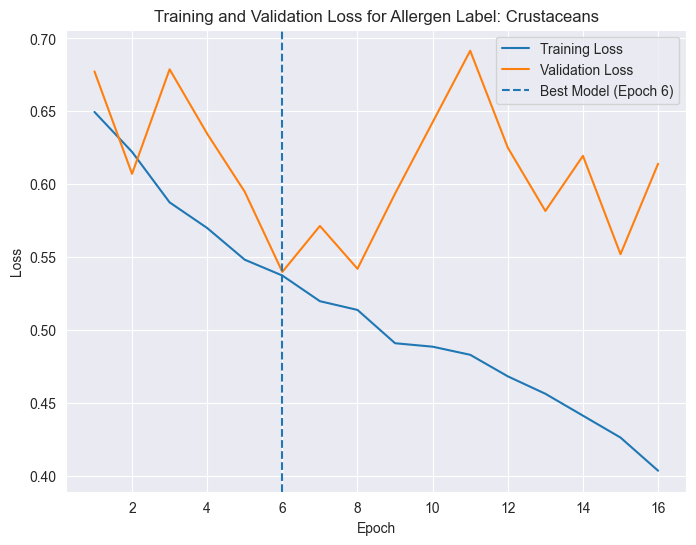

Test Error: 
 Accuracy: 72.05 % 




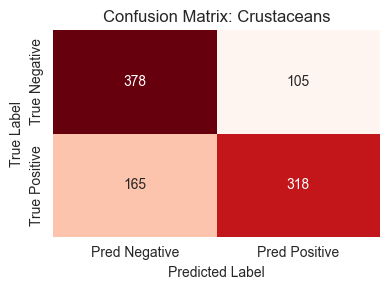



Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74       483
         1.0       0.75      0.66      0.70       483

    accuracy                           0.72       966
   macro avg       0.72      0.72      0.72       966
weighted avg       0.72      0.72      0.72       966



In [17]:
# trained with augments
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/10
Loss: 0.6884316 [    0/ 3862]
Loss: 0.6371784 [ 3200/ 3862]
Train loss for this epoch: 0.6397636
Validation loss for this epoch: 0.7448611
Saved new best model: Crustaceans.pt

Epoch 2/10
Loss: 0.5444476 [    0/ 3862]
Loss: 0.6503499 [ 3200/ 3862]
Train loss for this epoch: 0.6009559
Validation loss for this epoch: 1.3056135

Epoch 3/10
Loss: 0.6555128 [    0/ 3862]
Loss: 0.6115804 [ 3200/ 3862]
Train loss for this epoch: 0.5690737
Validation loss for this epoch: 0.6066171
Saved new best model: Crustaceans.pt

Epoch 4/10
Loss: 0.5903382 [    0/ 3862]
Loss: 0.6274805 [ 3200/ 3862]
Train loss for this epoch: 0.5463249
Validation loss for this epoch: 0.6312297

Epoch 5/10
Loss: 0.5343622 [    0/ 3862]
Loss: 0.5231863 [ 3200/ 3862]
Train loss for this epoch: 0.4839766
Validation loss for this epoch: 0.6138535

Epoch 6/10
Loss: 0.4400058 [    0/ 3862]
Loss: 0.55

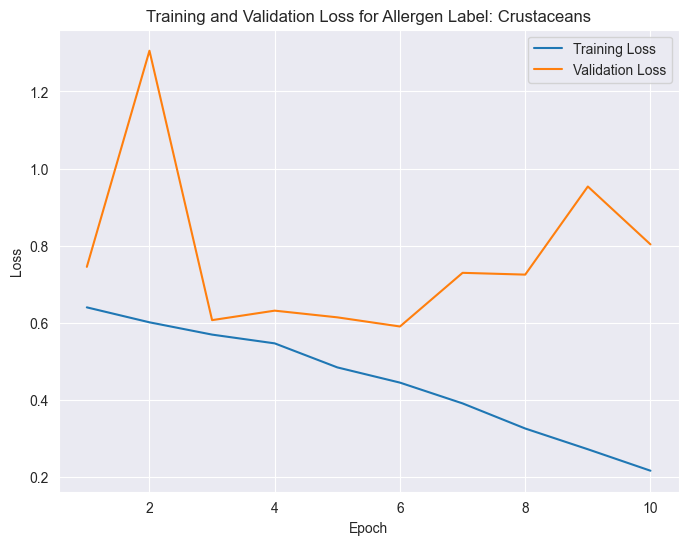

Test Error: 
 Accuracy: 69.25 % 




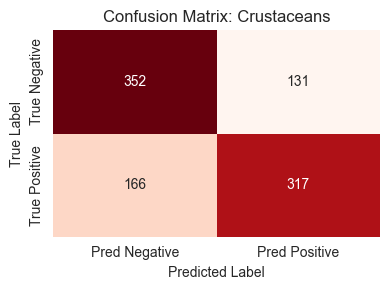



Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.73      0.70       483
         1.0       0.71      0.66      0.68       483

    accuracy                           0.69       966
   macro avg       0.69      0.69      0.69       966
weighted avg       0.69      0.69      0.69       966



In [72]:
# trained without augments
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 10,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

In [ ]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(0, x, y, hyperparameters)

Before resampling: 24485 positives, 37537 negatives
After resampling: 24485 positives, 24485 negatives

Using cuda device

Epoch 1/20
Loss: 0.7023039 [    0/34279]
Loss: 0.6288175 [ 6400/34279]


Before resampling: 18238 positives, 43784 negatives
After resampling: 18238 positives, 18238 negatives

Using cuda device

Epoch 1/20
Loss: 0.6831564 [    0/29180]
Loss: 0.6180993 [ 6400/29180]
Loss: 0.6726365 [12800/29180]
Loss: 0.6306965 [19200/29180]
Loss: 0.5982232 [25600/29180]
Train loss for this epoch: 0.6447512


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss for this epoch: 0.7184519
Saved new best model: Eggs.pt

Epoch 2/20
Loss: 0.6095185 [    0/29180]
Loss: 0.6847104 [ 6400/29180]
Loss: 0.6579901 [12800/29180]
Loss: 0.5739535 [19200/29180]
Loss: 0.6360675 [25600/29180]
Train loss for this epoch: 0.6203316
Validation loss for this epoch: 0.7235987

Epoch 3/20
Loss: 0.6095181 [    0/29180]
Loss: 0.6224118 [ 6400/29180]
Loss: 0.6467812 [12800/29180]
Loss: 0.5970954 [19200/29180]
Loss: 0.5687371 [25600/29180]
Train loss for this epoch: 0.6106386
Validation loss for this epoch: 0.7743016

Epoch 4/20
Loss: 0.6813799 [    0/29180]
Loss: 0.6096328 [ 6400/29180]
Loss: 0.6897492 [12800/29180]
Loss: 0.6238790 [19200/29180]
Loss: 0.6279039 [25600/29180]
Train loss for this epoch: 0.6038790
Validation loss for this epoch: 0.7291292

Epoch 5/20
Loss: 0.5522404 [    0/29180]
Loss: 0.5904118 [ 6400/29180]
Loss: 0.5570687 [12800/29180]
Loss: 0.5044389 [19200/29180]
Loss: 0.6741509 [25600/29180]
Train loss for this epoch: 0.5983927
Valida

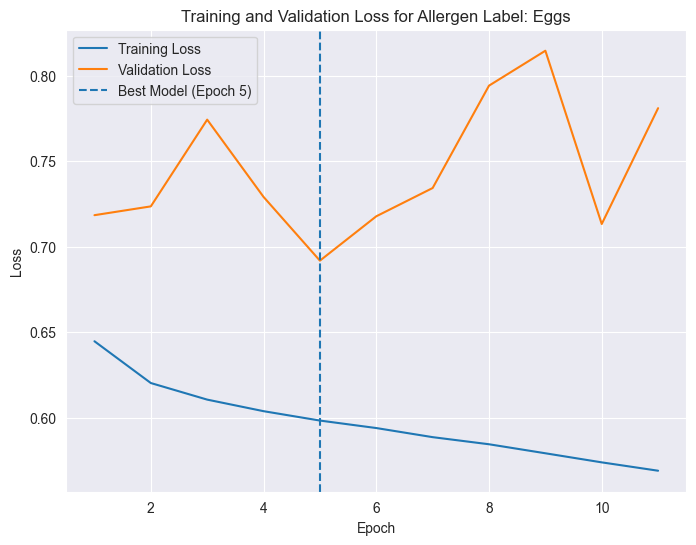

Test Error: 
 Accuracy: 56.81 % 




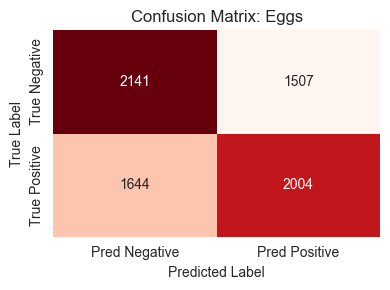



Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.59      0.58      3648
         1.0       0.57      0.55      0.56      3648

    accuracy                           0.57      7296
   macro avg       0.57      0.57      0.57      7296
weighted avg       0.57      0.57      0.57      7296



In [19]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(2, x, y, hyperparameters)

Before resampling: 8565 positives, 53457 negatives
After resampling: 8565 positives, 8565 negatives

Using cuda device

Epoch 1/20
Loss: 0.7029915 [    0/13704]
Loss: 0.6745462 [ 6400/13704]
Loss: 0.6473994 [12800/13704]
Train loss for this epoch: 0.6421814
Validation loss for this epoch: 0.6075737
Saved new best model: Fish.pt

Epoch 2/20
Loss: 0.6655893 [    0/13704]
Loss: 0.6962720 [ 6400/13704]
Loss: 0.5854616 [12800/13704]
Train loss for this epoch: 0.6219995
Validation loss for this epoch: 0.6070905
Saved new best model: Fish.pt

Epoch 3/20
Loss: 0.6006830 [    0/13704]
Loss: 0.5370519 [ 6400/13704]
Loss: 0.5915018 [12800/13704]
Train loss for this epoch: 0.6115673
Validation loss for this epoch: 0.5944494
Saved new best model: Fish.pt

Epoch 4/20
Loss: 0.6000007 [    0/13704]
Loss: 0.7171998 [ 6400/13704]
Loss: 0.7165851 [12800/13704]
Train loss for this epoch: 0.6050543
Validation loss for this epoch: 0.6115415

Epoch 5/20
Loss: 0.5590924 [    0/13704]
Loss: 0.5886570 [ 6400/13

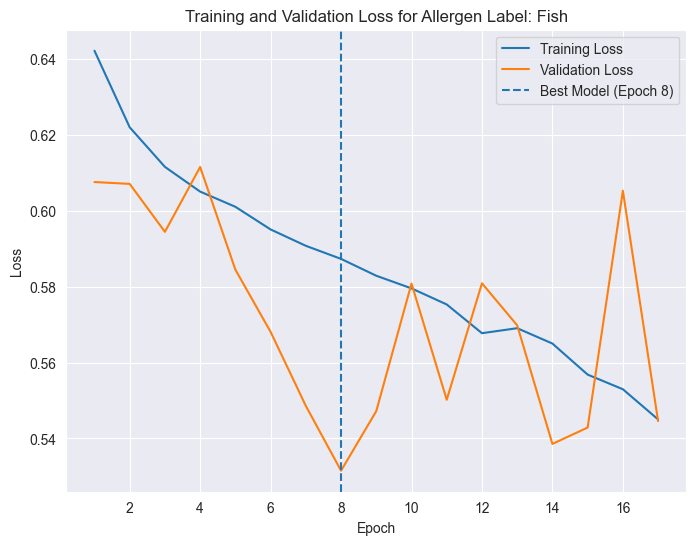

Test Error: 
 Accuracy: 72.56 % 




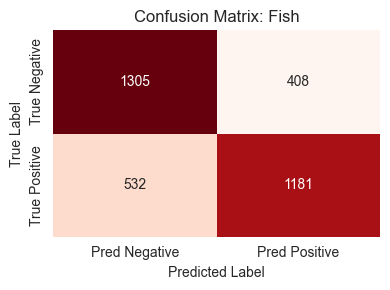



Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.76      0.74      1713
         1.0       0.74      0.69      0.72      1713

    accuracy                           0.73      3426
   macro avg       0.73      0.73      0.73      3426
weighted avg       0.73      0.73      0.73      3426



In [20]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(3, x, y, hyperparameters)

Before resampling: 2234 positives, 59788 negatives
After resampling: 2234 positives, 2234 negatives

Using cuda device

Epoch 1/20
Loss: 0.6934863 [    0/ 3574]
Loss: 0.6305310 [ 3200/ 3574]
Train loss for this epoch: 0.6843709
Validation loss for this epoch: 0.6952247
Saved new best model: Peanuts.pt

Epoch 2/20
Loss: 0.5941125 [    0/ 3574]
Loss: 0.5905777 [ 3200/ 3574]
Train loss for this epoch: 0.6622434
Validation loss for this epoch: 1.1719854

Epoch 3/20
Loss: 0.6789880 [    0/ 3574]
Loss: 0.6887311 [ 3200/ 3574]
Train loss for this epoch: 0.6531852
Validation loss for this epoch: 0.7430350

Epoch 4/20
Loss: 0.6862957 [    0/ 3574]
Loss: 0.6604357 [ 3200/ 3574]
Train loss for this epoch: 0.6441196
Validation loss for this epoch: 0.7237777

Epoch 5/20
Loss: 0.6223826 [    0/ 3574]
Loss: 0.6558131 [ 3200/ 3574]
Train loss for this epoch: 0.6362697
Validation loss for this epoch: 0.6774882
Saved new best model: Peanuts.pt

Epoch 6/20
Loss: 0.6319014 [    0/ 3574]
Loss: 0.6580871 [ 

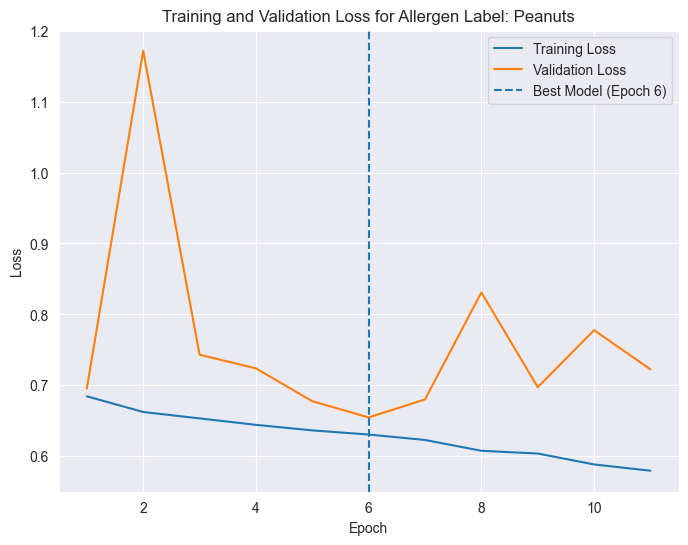

Test Error: 
 Accuracy: 62.30 % 




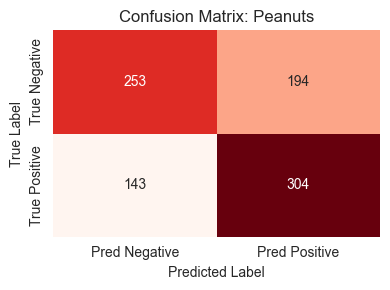



Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60       447
         1.0       0.61      0.68      0.64       447

    accuracy                           0.62       894
   macro avg       0.62      0.62      0.62       894
weighted avg       0.62      0.62      0.62       894



In [21]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(4, x, y, hyperparameters)

Before resampling: 4264 positives, 57758 negatives
After resampling: 4264 positives, 4264 negatives

Using cuda device

Epoch 1/20
Loss: 0.7039124 [    0/ 6822]
Loss: 0.5940839 [ 3200/ 6822]
Loss: 0.6078598 [ 6400/ 6822]
Train loss for this epoch: 0.6667032
Validation loss for this epoch: 0.7042212
Saved new best model: Soybeans.pt

Epoch 2/20
Loss: 0.7157471 [    0/ 6822]
Loss: 0.6782454 [ 3200/ 6822]
Loss: 0.6610570 [ 6400/ 6822]
Train loss for this epoch: 0.6429561
Validation loss for this epoch: 0.6578812
Saved new best model: Soybeans.pt

Epoch 3/20
Loss: 0.6826147 [    0/ 6822]
Loss: 0.6151778 [ 3200/ 6822]
Loss: 0.5788435 [ 6400/ 6822]
Train loss for this epoch: 0.6286908
Validation loss for this epoch: 0.6592681

Epoch 4/20
Loss: 0.5349358 [    0/ 6822]
Loss: 0.5560485 [ 3200/ 6822]
Loss: 0.6763695 [ 6400/ 6822]
Train loss for this epoch: 0.6185740
Validation loss for this epoch: 0.6079211
Saved new best model: Soybeans.pt

Epoch 5/20
Loss: 0.5897955 [    0/ 6822]
Loss: 0.55378

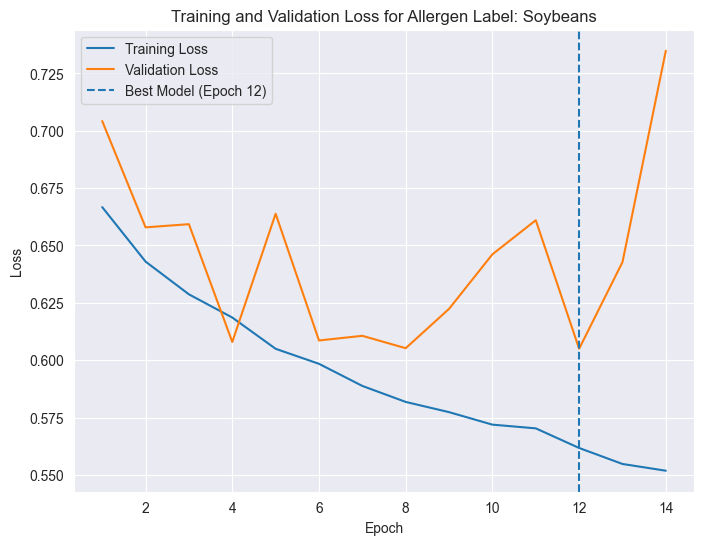

Test Error: 
 Accuracy: 67.00 % 




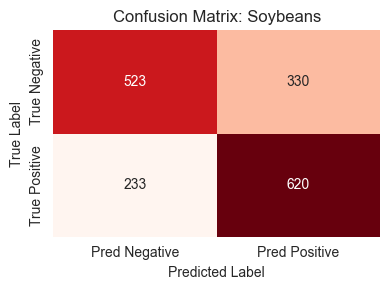



Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65       853
         1.0       0.65      0.73      0.69       853

    accuracy                           0.67      1706
   macro avg       0.67      0.67      0.67      1706
weighted avg       0.67      0.67      0.67      1706



In [22]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(5, x, y, hyperparameters)

Before resampling: 38201 positives, 23821 negatives
After resampling: 23821 positives, 23821 negatives

Using cuda device

Epoch 1/20
Loss: 0.6821166 [    0/38113]
Loss: 0.6528948 [ 6400/38113]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.6617637 [12800/38113]
Loss: 0.6600649 [19200/38113]
Loss: 0.6746269 [25600/38113]
Loss: 0.6344092 [32000/38113]
Train loss for this epoch: 0.6493475
Validation loss for this epoch: 0.7203771
Saved new best model: Milk.pt

Epoch 2/20
Loss: 0.6107925 [    0/38113]
Loss: 0.6528397 [ 6400/38113]
Loss: 0.6994396 [12800/38113]
Loss: 0.6295404 [19200/38113]
Loss: 0.6555905 [25600/38113]
Loss: 0.6783010 [32000/38113]
Train loss for this epoch: 0.6291868
Validation loss for this epoch: 0.7154743
Saved new best model: Milk.pt

Epoch 3/20
Loss: 0.6252351 [    0/38113]
Loss: 0.6491871 [ 6400/38113]
Loss: 0.5990890 [12800/38113]
Loss: 0.5760082 [19200/38113]
Loss: 0.5553084 [25600/38113]
Loss: 0.5498281 [32000/38113]
Train loss for this epoch: 0.6159999
Validation loss for this epoch: 0.6897971
Saved new best model: Milk.pt

Epoch 4/20
Loss: 0.6476938 [    0/38113]
Loss: 0.7097384 [ 6400/38113]
Loss: 0.6065428 [12800/38113]
Loss: 0.6569019 [19200/38113]
Loss: 0.5826401 [25600/38113]
Loss: 0

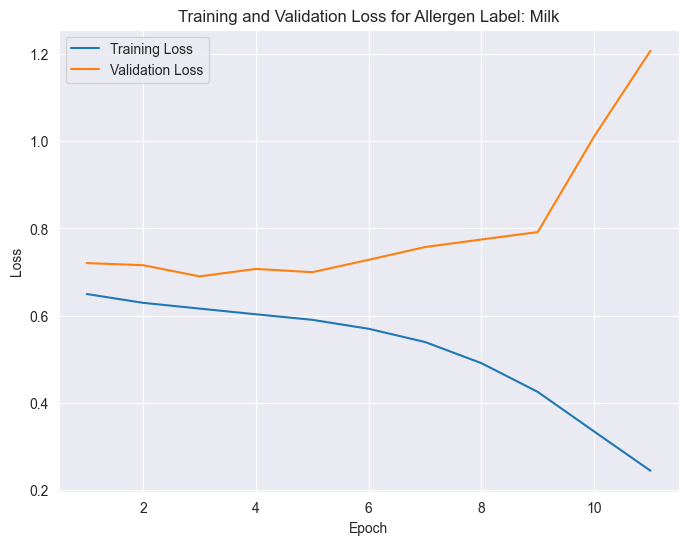

Test Error: 
 Accuracy: 57.73 % 




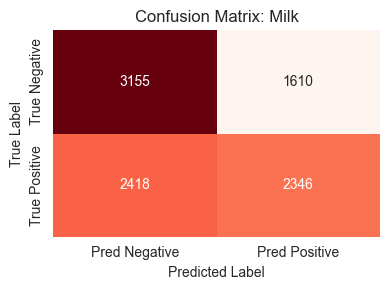



Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61      4765
         1.0       0.59      0.49      0.54      4764

    accuracy                           0.58      9529
   macro avg       0.58      0.58      0.57      9529
weighted avg       0.58      0.58      0.57      9529



In [73]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(6, x, y, hyperparameters)

Before resampling: 4704 positives, 57318 negatives
After resampling: 4704 positives, 4704 negatives

Using cuda device

Epoch 1/20
Loss: 0.7081144 [    0/ 7526]
Loss: 0.6421953 [ 3200/ 7526]
Loss: 0.7132460 [ 6400/ 7526]
Train loss for this epoch: 0.6841288
Validation loss for this epoch: 0.6762202
Saved new best model: Nuts.pt

Epoch 2/20
Loss: 0.6895865 [    0/ 7526]
Loss: 0.6668705 [ 3200/ 7526]
Loss: 0.7696584 [ 6400/ 7526]
Train loss for this epoch: 0.6737569
Validation loss for this epoch: 0.6700360
Saved new best model: Nuts.pt

Epoch 3/20
Loss: 0.7387388 [    0/ 7526]
Loss: 0.6350319 [ 3200/ 7526]
Loss: 0.6479547 [ 6400/ 7526]
Train loss for this epoch: 0.6652737
Validation loss for this epoch: 0.7160686

Epoch 4/20
Loss: 0.6021975 [    0/ 7526]
Loss: 0.6214816 [ 3200/ 7526]
Loss: 0.6343307 [ 6400/ 7526]
Train loss for this epoch: 0.6578524
Validation loss for this epoch: 0.6684387
Saved new best model: Nuts.pt

Epoch 5/20
Loss: 0.7162399 [    0/ 7526]
Loss: 0.7094892 [ 3200/ 7

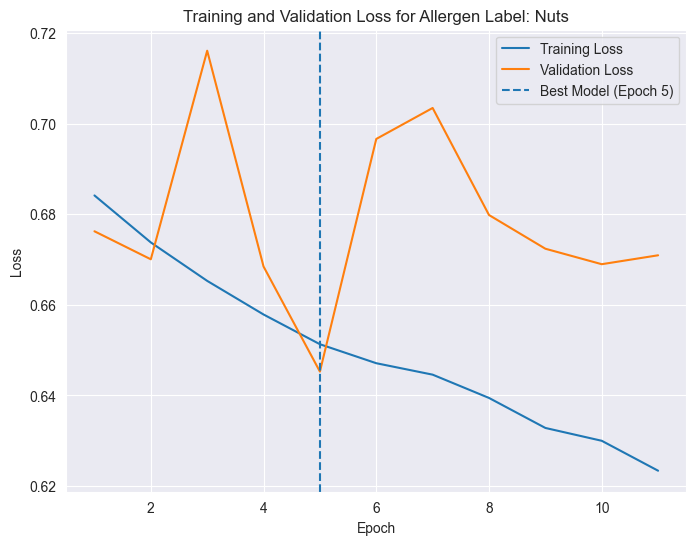

Test Error: 
 Accuracy: 63.97 % 




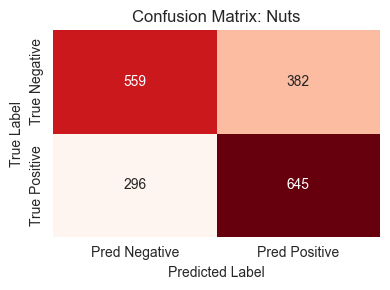



Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.59      0.62       941
         1.0       0.63      0.69      0.66       941

    accuracy                           0.64      1882
   macro avg       0.64      0.64      0.64      1882
weighted avg       0.64      0.64      0.64      1882



In [23]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(7, x, y, hyperparameters)

Before resampling: 3733 positives, 58289 negatives
After resampling: 3733 positives, 3733 negatives

Using cuda device

Epoch 1/20
Loss: 0.6837224 [    0/ 5972]
Loss: 0.6617389 [ 3200/ 5972]
Train loss for this epoch: 0.6811785
Validation loss for this epoch: 0.6904861
Saved new best model: Celery.pt

Epoch 2/20
Loss: 0.6102252 [    0/ 5972]
Loss: 0.7072803 [ 3200/ 5972]
Train loss for this epoch: 0.6678171
Validation loss for this epoch: 0.8614678

Epoch 3/20
Loss: 0.6761432 [    0/ 5972]
Loss: 0.7322499 [ 3200/ 5972]
Train loss for this epoch: 0.6548912
Validation loss for this epoch: 0.7060683

Epoch 4/20
Loss: 0.6902626 [    0/ 5972]
Loss: 0.6667398 [ 3200/ 5972]
Train loss for this epoch: 0.6447910
Validation loss for this epoch: 0.7811646

Epoch 5/20
Loss: 0.6755046 [    0/ 5972]
Loss: 0.6994336 [ 3200/ 5972]
Train loss for this epoch: 0.6365768
Validation loss for this epoch: 0.6823351
Saved new best model: Celery.pt

Epoch 6/20
Loss: 0.5809639 [    0/ 5972]
Loss: 0.7039860 [ 32

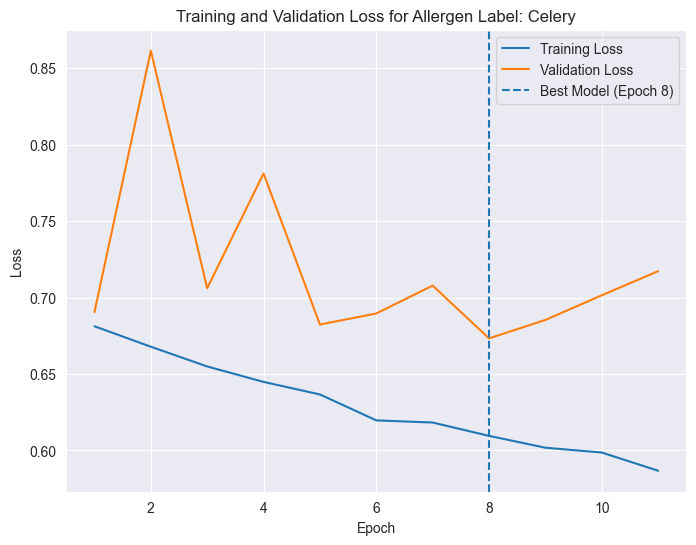

Test Error: 
 Accuracy: 60.44 % 




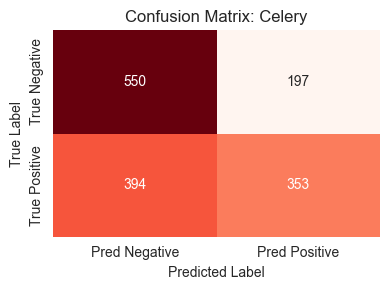



Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.74      0.65       747
         1.0       0.64      0.47      0.54       747

    accuracy                           0.60      1494
   macro avg       0.61      0.60      0.60      1494
weighted avg       0.61      0.60      0.60      1494



In [24]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(8, x, y, hyperparameters)

Before resampling: 4263 positives, 57759 negatives
After resampling: 4263 positives, 4263 negatives

Using cuda device

Epoch 1/20
Loss: 0.7117666 [    0/ 6820]
Loss: 0.7007557 [ 3200/ 6820]
Loss: 0.6874560 [ 6400/ 6820]
Train loss for this epoch: 0.6939448
Validation loss for this epoch: 0.7228204
Saved new best model: Mustard.pt

Epoch 2/20
Loss: 0.7470291 [    0/ 6820]
Loss: 0.6937159 [ 3200/ 6820]
Loss: 0.7063107 [ 6400/ 6820]
Train loss for this epoch: 0.6916575
Validation loss for this epoch: 0.6823528
Saved new best model: Mustard.pt

Epoch 3/20
Loss: 0.6901413 [    0/ 6820]
Loss: 0.6807326 [ 3200/ 6820]
Loss: 0.6963494 [ 6400/ 6820]
Train loss for this epoch: 0.6876212
Validation loss for this epoch: 0.6943694

Epoch 4/20
Loss: 0.6644493 [    0/ 6820]
Loss: 0.6747763 [ 3200/ 6820]
Loss: 0.7502192 [ 6400/ 6820]
Train loss for this epoch: 0.6875058
Validation loss for this epoch: 0.8052902

Epoch 5/20
Loss: 0.6362724 [    0/ 6820]
Loss: 0.7080902 [ 3200/ 6820]
Loss: 0.6842343 [ 6

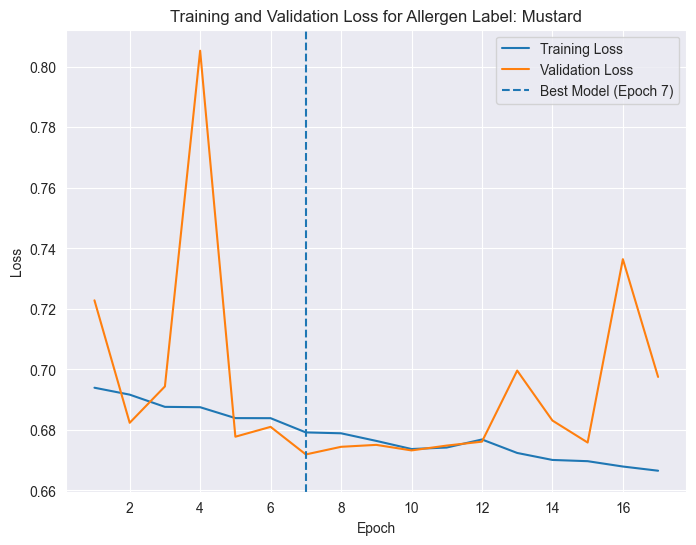

Test Error: 
 Accuracy: 60.84 % 




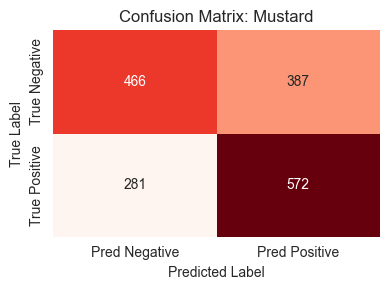



Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.55      0.58       853
         1.0       0.60      0.67      0.63       853

    accuracy                           0.61      1706
   macro avg       0.61      0.61      0.61      1706
weighted avg       0.61      0.61      0.61      1706



In [25]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(9, x, y, hyperparameters)

Before resampling: 1862 positives, 60160 negatives
After resampling: 1862 positives, 1862 negatives

Using cuda device

Epoch 1/20
Loss: 0.6850179 [    0/ 2979]
Train loss for this epoch: 0.6652939
Validation loss for this epoch: 0.6387382
Saved new best model: Sesame seeds.pt

Epoch 2/20
Loss: 0.7010327 [    0/ 2979]
Train loss for this epoch: 0.6541065
Validation loss for this epoch: 0.6144527
Saved new best model: Sesame seeds.pt

Epoch 3/20
Loss: 0.5904968 [    0/ 2979]
Train loss for this epoch: 0.6601147
Validation loss for this epoch: 0.6140029
Saved new best model: Sesame seeds.pt

Epoch 4/20
Loss: 0.6086763 [    0/ 2979]
Train loss for this epoch: 0.6412573
Validation loss for this epoch: 0.6232119

Epoch 5/20
Loss: 0.6727635 [    0/ 2979]
Train loss for this epoch: 0.6305247
Validation loss for this epoch: 0.5932100
Saved new best model: Sesame seeds.pt

Epoch 6/20
Loss: 0.5911713 [    0/ 2979]
Train loss for this epoch: 0.6276714
Validation loss for this epoch: 0.6545128

Ep

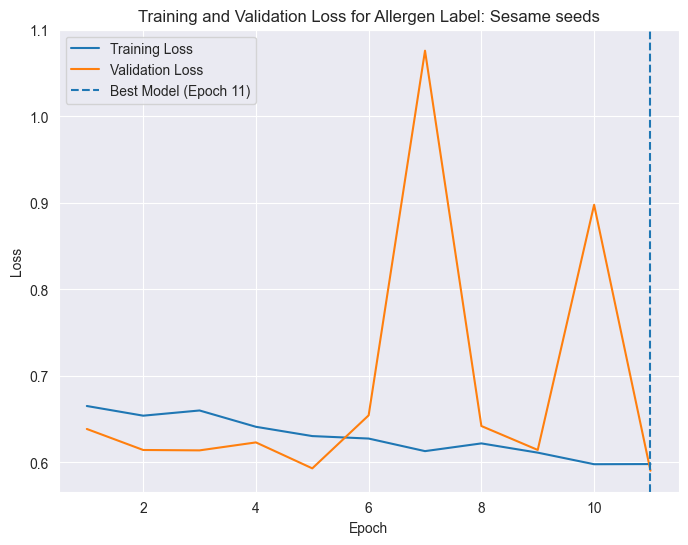

Test Error: 
 Accuracy: 68.19 % 




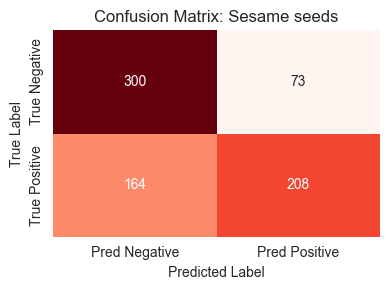



Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.80      0.72       373
         1.0       0.74      0.56      0.64       372

    accuracy                           0.68       745
   macro avg       0.69      0.68      0.68       745
weighted avg       0.69      0.68      0.68       745



In [26]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(10, x, y, hyperparameters)

Before resampling: 875 positives, 61147 negatives
After resampling: 875 positives, 875 negatives

Using cuda device

Epoch 1/20
Loss: 0.6896480 [    0/ 1400]
Train loss for this epoch: 0.6476913
Validation loss for this epoch: 0.6973805
Saved new best model: Molluscs.pt

Epoch 2/20
Loss: 0.6182477 [    0/ 1400]
Train loss for this epoch: 0.6064116
Validation loss for this epoch: 0.7427318

Epoch 3/20
Loss: 0.6237787 [    0/ 1400]
Train loss for this epoch: 0.6007487
Validation loss for this epoch: 0.6321517
Saved new best model: Molluscs.pt

Epoch 4/20
Loss: 0.4726624 [    0/ 1400]
Train loss for this epoch: 0.5636611
Validation loss for this epoch: 0.7224671

Epoch 5/20
Loss: 0.5337037 [    0/ 1400]
Train loss for this epoch: 0.5279450
Validation loss for this epoch: 0.6257667
Saved new best model: Molluscs.pt

Epoch 6/20
Loss: 0.3818548 [    0/ 1400]
Train loss for this epoch: 0.5154403
Validation loss for this epoch: 0.6436952

Epoch 7/20
Loss: 0.5632222 [    0/ 1400]
Train loss for

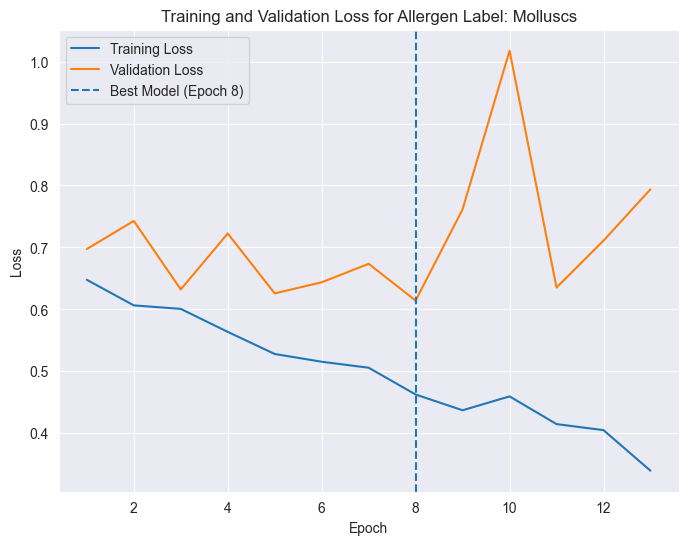

Test Error: 
 Accuracy: 69.71 % 




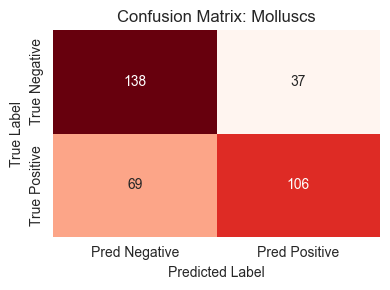



Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.79      0.72       175
         1.0       0.74      0.61      0.67       175

    accuracy                           0.70       350
   macro avg       0.70      0.70      0.69       350
weighted avg       0.70      0.70      0.69       350



In [27]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(13, x, y, hyperparameters)